In [1]:
#this version is for the DPS plots
%matplotlib inline

#packages
from scipy.integrate import simpson
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from math import pi, sqrt
from mpl_toolkits import mplot3d
import mpld3

In [2]:
#variables
P_earth = 100*1000 #100 kPa, this is in units of Pa in the code
P_surf = 147*1000 #Pa at the surface on Titan, update this as need be
r_Horz = 0*1000 #m, radial distance from the vertical burst point?
P_amb = P_surf #Pa is the ambient pressure of whatever we're interested in
d =  r_Horz #m, this is the HORIZONTAL distance, so d = 0 for directly down
dz = 0.1 #km, the step interval for the atmospheric entry simulation
c = 299792458. #m/s
t_G = 1.352 #m/s2 gravitational acceleration on titan


vDefault = 10*1000 #m/s
rhoDefault = 500
rDefault = 1
r_scaleDefault = 1.0
m_scaleDefault = 0.9
lum_effDefault = 0.01 #~1 - 5%, this is the reduction of kinetic energy 
strengthList = [s/1000 for s in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]] #kPa to Pa
#reference titan density profile
csv_path = "C:/Users/elisa/University/York/Airbursts/code/titan_density_elisa.txt" 

In [3]:
#functions for back of envelope calculation
def z_interp_str(strength): #intakes density to find height
    '''the y_val is the density, x is the height z in km'''
    input_csv = csv_path
    rawData = pd.read_csv(input_csv, header=None, sep='\t')
    heights = list(rawData.iloc[:,0])
    densities = list(rawData.iloc[:,1]) #this is in kg/m3
    pressures = [d*t_G*z for d, z in zip(densities, heights)] 
    f = interp1d(pressures, heights)
    z_burst = f(strength)
    return z_burst*1000 #return it in m

# #mass calculator
def mass_calc(rho=rhoDefault, rad=rDefault):
    '''assuming kg/m^3 and m units'''
    volume = (4/3)*pi*(rad**3)
    mass = rho*volume
    return mass

#ram pressure
def p_burst(v=vDefault, rho=rhoDefault):
    #[m/s, kg/m3]
    return rho*(v**2)

def KE(m, v):
    #mass in kg, v in m/s
    E = 0.5 * m* (v**2)
    E_scale = E/4.184e12
    return E_scale

In [4]:
#overpressure calculations
def D_m_slant(D_m, rHorz = r_Horz):
    return sqrt(D_m**2 + rHorz**2)

def p_M_slant(D_m_slant, W_burst, P_earth=P_earth, P_amb=P_amb):
    d_mod_power_atm = D_m_slant/((W_burst**(1/3))*((P_earth/P_amb)**(1/3))) 
    p_M_slant = (3.14E11*(d_mod_power_atm**-2.6) + 1.8E7*(d_mod_power_atm**-1.13))*(P_amb/P_earth) 
    return p_M_slant 

def p_M_slant_comp(DM_slant, W, P0=P_earth, P=P_amb):
    P_M_scale = (P0/P)**(1/3) 
    overpressureA = 3.14E11*((DM_slant/P_M_scale)**-2.6)
    overpressureB = 1.8E7*((DM_slant/P_M_scale)**-1.13)
    pressure_correct = (overpressureA + overpressureB)*(P/P0)
    return pressure_correct

#overpressure steps
def overpressure(z, lum_eff = lum_effDefault, v=vDefault, rho=rhoDefault, rad = rDefault, m_s = m_scaleDefault):
    mass = mass_calc(rad=rad*r_scaleDefault, rho=rho) 
    E = KE(mass, v)
    eff = 1. - lum_eff
    E_eff = eff*E
    W_burst = E_eff #kt/TNT
    z_burst = z #m, height of burst, this is based on velocity ALONE
    D_M_slant = D_m_slant(z_burst)
    P_M= p_M_slant(D_M_slant, W_burst, P_earth, P_amb)#Pa(m, ktTNT, Pa, Pa)
    return P_M

In [5]:
#overpressure for back of envelop
def op_info(rVal, rho, v=vDefault, m_s=m_scaleDefault):   
    z_burstList = []
    for s in strengthList:
        z_burst = z_interp_str(s)
        z_burstList += [z_burst]
    opList = []
    for z_burst in z_burstList:
        op = overpressure(z_burst, rho=rho, rad=rVal, m_s = m_s) #in Pascals
        opList += [op]
    return z_burstList, opList

In [6]:
#overpressure for fcm
def burst_Info(fPath, r):
    f = open(fPath, 'rb')
    data = pkl.load(f)
    f.close()
    nList = list(range(1, len(data)+1)) #this is saved as a dictionary, so it's keys
    EcumList = []
    EtangentList = []
    EinitList = []
    zmaxList = []
    for n in nList:
        yVals = list(data[n][2]) #dE/dz
        xVals = list(data[n][3]) #z
        dz = abs(xVals[0]-xVals[1])
        E_ind_max = yVals.index(max(yVals))
        E_ind = 0
        E_cum = 0
        for dE in yVals:
            if E_ind <= E_ind_max:
                E_cum += dE*dz
                E_ind += 1
        EcumList += [E_cum]
        EtangentList += [abs(yVals[E_ind_max]-yVals[E_ind_max-1])/dz] #the tangent to get instantaneous energy
        m = mass_calc(rad=r)
        EinitList += [KE(m, v = vDefault)]
        zmaxList += [xVals[yVals.index(max(yVals))]]
    return zmaxList, EcumList, EtangentList, EinitList

In [7]:
#plotting the overpressures
rList = [1,2,3]
strList = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0] #kPa
path = 'C:/Users/elisa/University/York/Airbursts/data/ice_lowStr/v10/'
filePathList = []
opcumList = []
opinitList = []
optangList = []
    
for r in rList:
    filePathList += [path + 'airburstList_0{}.pkl'.format(r)]

for r, fPath in zip(rList, filePathList): #can set this to plot multiple images at once, or to stack the results on one plot
    zmaxList, EcumList, EtangentList, EinitList = burst_Info(fPath, r) #no change in units, should be km, ktTNT
    PMcumList = []
    PMtangList = []
    PMinitList = []
    for z, Ecum, Etang, Einit in zip(zmaxList, EcumList, EtangentList, EinitList):
        P_Minit = p_M_slant(z*1000,Einit)
        P_Mcum = p_M_slant(z*1000,Ecum)
        P_Mtang = p_M_slant(z*1000,Etang)
        PMinitList += [P_Minit]
        PMcumList += [P_Mcum]
        PMtangList += [P_Mtang]
    opcumList += [PMcumList[3:]]
    opinitList += [PMinitList[3:]]
    optangList += [PMtangList[3:]]
        
    
rList = [4, 5]
strList = [0.05, 0.1, 0.5, 1.0] #kPa
path = 'C:/Users/elisa/University/York/Airbursts/data/ice_lowStr/v10/'
filePathList = []

for r in rList:
    filePathList += [path + 'airburstList_0{}_0_05.pkl'.format(r)]
    
for r, fPath in zip(rList, filePathList): #can set this to plot multiple images at once, or to stack the results on one plot
    zmaxList, EcumList, EtangentList, EinitList = burst_Info(fPath, r) #no change in units, should be km, ktTNT
    PMcumList = []
    PMtangList = []
    PMinitList = []
    for z, Ecum, Etang, Emax in zip(zmaxList, EcumList, EtangentList, EinitList):
        P_Minit = p_M_slant(z*1000,Einit)
        P_Mcum = p_M_slant(z*1000,Ecum)
        P_Mtang = p_M_slant(z*1000,Etang)
        PMinitList += [P_Minit]
        PMcumList += [P_Mcum]
        PMtangList += [P_Mtang]
    opcumList += [PMcumList]
    opinitList += [PMinitList]
    optangList += [PMtangList]
    

In [8]:
#BOE calculations
rho = 500
rList = [1, 2, 3, 4, 5] #in m
zBOEList = []
opBOEList = []
strengthList = [s/1000 for s in [0.05, 0.1, 0.5, 1.0]] #needs to be read in as Pa

for r in rList:
    zList, opList = op_info(r, rho)
    zBOEList += [zList]
    opBOEList += [opList]
    

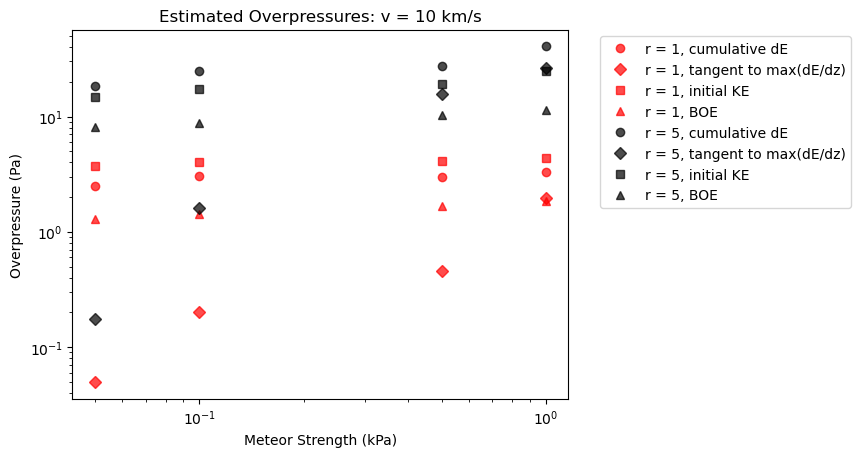

In [9]:
rList = [1, 2, 3, 4, 5]
strList = [0.05, 0.1, 0.5, 1.0]
colorList = ['r', 'g', 'b', 'c', 'k']

for r, c in zip(rList, colorList):
    rInd = rList.index(r)
    if r in [1, 5]:
        plt.plot(strList, opcumList[rInd], 'o', color = c, alpha = 0.7, label = 'r = {}, cumulative dE'.format(r))
        plt.plot(strList, optangList[rInd], 'D', color = c, alpha = 0.7, label = 'r = {}, tangent to max(dE/dz)'.format(r))
        plt.plot(strList, opinitList[rInd], 's', color = c, alpha = 0.7, label = 'r = {}, initial KE'.format(r))
        plt.plot(strList, opBOEList[rInd], '^', color = c, alpha = 0.7, label = 'r = {}, BOE'.format(r))
    
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('Overpressure (Pa)')
plt.xlabel('Meteor Strength (kPa)')
plt.title('Estimated Overpressures: v = 10 km/s')
plt.yscale('log')
plt.xscale('log')
# plt.savefig('dps_op_v10.png', bbox_inches="tight")

Text(0.5, 0, 'Overpressure (Pa)')

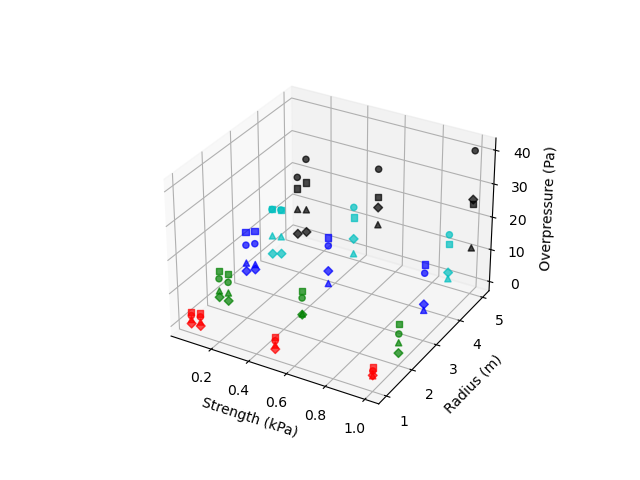

In [10]:
%matplotlib widget

rList = [1, 2, 3, 4, 5]
strList = [0.05, 0.1, 0.5, 1.0]
colorList = ['r', 'g', 'b', 'c', 'k']
markerList = ['o','D','s','^']

fig = plt.figure()
ax = plt.axes(projection='3d')


for r, c in zip(rList, colorList):
    rInd = rList.index(r)
    if r in [1, 2, 3, 4, 5]:
        ax.scatter3D(strList, [r]*len(strList), opcumList[rInd], marker = markerList[0], color = c, alpha = 0.7, label = 'r = {}, cumulative dE'.format(r))
        ax.scatter3D(strList, [r]*len(strList), optangList[rInd], marker = markerList[1], color = c, alpha = 0.7, label = 'r = {}, tangent to max(dE/dz)'.format(r))
        ax.scatter3D(strList, [r]*len(strList), opinitList[rInd], marker = markerList[2], color = c, alpha = 0.7, label = 'r = {}, initial KE'.format(r))
        ax.scatter3D(strList, [r]*len(strList), opBOEList[rInd], marker = markerList[3], color = c, alpha = 0.7, label = 'r = {}, cumulative BOE'.format(r))
    
ax.set_xlabel('Strength (kPa)')
ax.set_ylabel('Radius (m)')
ax.set_zlabel('Overpressure (Pa)')